COMSOL Dataset Preprocessing for Blochskyr_STT_1e12_1_0.05

Import Lib

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
csv_path = "../Data_Output/bloch_STT_7e10_sweep6.csv"
df = pd.read_csv(csv_path, skiprows=8)

num_cols = df.shape[1]
print("Number of columns in the CSV file:", num_cols)

num_parameter_pairs = (num_cols - 3) / 7
print("Number of parameter pairs:", num_parameter_pairs)

Number of columns in the CSV file: 283
Number of parameter pairs: 40.0


Determine Centre of SKyrmion

In [3]:
from sklearn.cluster import DBSCAN
import numpy as np

def find_skyrmion_center_by_clustering(df,
                                       mz_col=None,
                                       x_col="% X", y_col="Y",
                                       threshold=0.5,
                                       eps=5.0, min_samples=5):
    """
    找出 mZ > 阈值 的点，做 DBSCAN 聚类，取最大簇的中心。
    适用于非规则网格。

    返回:
        x_center, y_center, mz_avg
    """
    if mz_col is None:
        mz_candidates = [col for col in df.columns if 'mZ' in col and '@' in col]
        if not mz_candidates:
            raise ValueError("未找到 mZ 列")
        mz_col = mz_candidates[0]

    # 选出高于阈值的点
    df_high = df[df[mz_col] > threshold].copy()
    if df_high.empty:
        return np.nan, np.nan, np.nan

    coords = df_high[[x_col, y_col]].values

    # DBSCAN 聚类
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(coords)
    df_high["cluster"] = clustering.labels_

    # 只保留最大簇（忽略 -1 噪声）
    valid_clusters = df_high[df_high["cluster"] != -1]["cluster"]
    if valid_clusters.empty:
        return np.nan, np.nan, np.nan

    main_cluster = valid_clusters.value_counts().idxmax()
    df_main = df_high[df_high["cluster"] == main_cluster]

    # 取几何中心或加权中心
    x_center = df_main[x_col].mean()
    y_center = df_main[y_col].mean()
    mz_avg = df_main[mz_col].mean()

    # print("mZ max:", df[mz_col].max())
    # print("mZ threshold used:", threshold)
    # print("Number of points > threshold:", len(df_high))

    return x_center, y_center, mz_avg


In [4]:
print(df.head())

          % X           Y             t  mX (1) @ alpha=0.005; beta=0  \
0 -365.285065 -139.856481  0.000000e+00                  2.607469e-07   
1 -365.285065 -139.856481  5.050505e-10                 -3.502576e-03   
2 -365.285065 -139.856481  1.010101e-09                 -1.088976e-03   
3 -365.285065 -139.856481  1.515152e-09                 -1.309845e-03   
4 -365.285065 -139.856481  2.020202e-09                 -2.251857e-03   

   mY (1) @ alpha=0.005; beta=0  mZ (1) @ alpha=0.005; beta=0  \
0                 -9.933904e-09                     -1.000000   
1                 -6.409104e-04                     -0.999996   
2                 -6.170104e-04                     -0.999999   
3                  7.577098e-05                     -0.999999   
4                  1.120043e-03                     -0.999997   

   mm.alpha (1) @ alpha=0.005; beta=0  mm.beta (1) @ alpha=0.005; beta=0  \
0                               0.005                                  0   
1                 

Example of Mz graph for single timeframe 

使用的 mZ 列是: mZ (1) @ alpha=0.005; beta=0


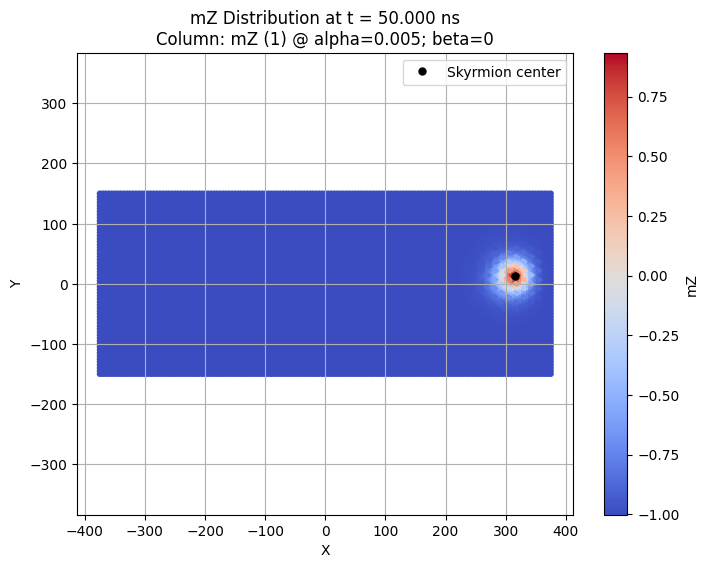

In [33]:

# ===== 1. 识别所有 mZ 列 =====
mz_candidates = [col for col in df.columns if 'mZ' in col and '@' in col]

# ===== 2. 用户选择：要使用哪个 mZ 列（通过索引）=====
# 你可以修改这个 index 来选择不同的 mZ 列
mz_index = 0  # 例如用第 0 个 mZ 列，可改为 1、2 等
mz_col = mz_candidates[mz_index]

print(f"使用的 mZ 列是: {mz_col}")

# ===== 3. 选择某一帧时间点 =====
t_array = np.sort(df["t"].unique())
target_time = t_array[99]  # 选第 100 帧

df_singleframe = df[df["t"] == target_time].copy()

# ===== 4. 计算 skyrmion 中心 =====
x_center, y_center, _ = find_skyrmion_center_by_clustering(
    df_singleframe,
    mz_col=mz_col,
    x_col="% X",
    y_col="Y",
    threshold=0.3,
    eps=8.0,
    min_samples=5
)

# ===== 5. 准备数据并绘图 =====
X = df_singleframe["% X"]
Y = df_singleframe["Y"]
mZ = df_singleframe[mz_col]

plt.figure(figsize=(8, 6))
sc = plt.scatter(X, Y, c=mZ, cmap="coolwarm", s=20, edgecolors='none')
plt.colorbar(sc, label="mZ")
plt.xlabel("X")
plt.ylabel("Y")
plt.title(f"mZ Distribution at t = {target_time*1e9:.3f} ns\nColumn: {mz_col}")
plt.axis("equal")
plt.grid(True)

if not np.isnan(x_center) and not np.isnan(y_center):
    plt.plot(x_center, y_center, 'ko', markersize=5, label="Skyrmion center")
    plt.legend()

plt.show()

Skyrmion Tracjectories for single timeframe

可选的 mZ 列：
[0] mZ (1) @ alpha=0.005; beta=0
[1] mZ (1) @ alpha=0.005; beta=0.01
[2] mZ (1) @ alpha=0.005; beta=0.02
[3] mZ (1) @ alpha=0.005; beta=0.04
[4] mZ (1) @ alpha=0.005; beta=0.08
[5] mZ (1) @ alpha=0.005; beta=0.12
[6] mZ (1) @ alpha=0.005; beta=0.2
[7] mZ (1) @ alpha=0.005; beta=0.3
[8] mZ (1) @ alpha=0.01; beta=0
[9] mZ (1) @ alpha=0.01; beta=0.01
[10] mZ (1) @ alpha=0.01; beta=0.02
[11] mZ (1) @ alpha=0.01; beta=0.04
[12] mZ (1) @ alpha=0.01; beta=0.08
[13] mZ (1) @ alpha=0.01; beta=0.12
[14] mZ (1) @ alpha=0.01; beta=0.2
[15] mZ (1) @ alpha=0.01; beta=0.3
[16] mZ (1) @ alpha=0.02; beta=0
[17] mZ (1) @ alpha=0.02; beta=0.01
[18] mZ (1) @ alpha=0.02; beta=0.02
[19] mZ (1) @ alpha=0.02; beta=0.04
[20] mZ (1) @ alpha=0.02; beta=0.08
[21] mZ (1) @ alpha=0.02; beta=0.12
[22] mZ (1) @ alpha=0.02; beta=0.2
[23] mZ (1) @ alpha=0.02; beta=0.3
[24] mZ (1) @ alpha=0.04; beta=0
[25] mZ (1) @ alpha=0.04; beta=0.01
[26] mZ (1) @ alpha=0.04; beta=0.02
[27] mZ (1) @ alpha=0.04; beta=0.04
[2

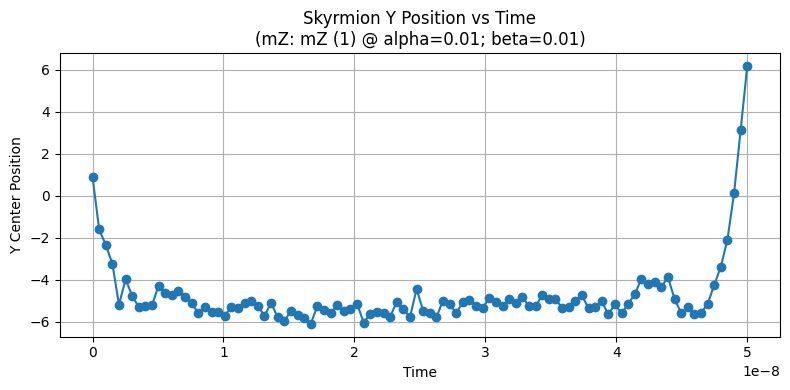

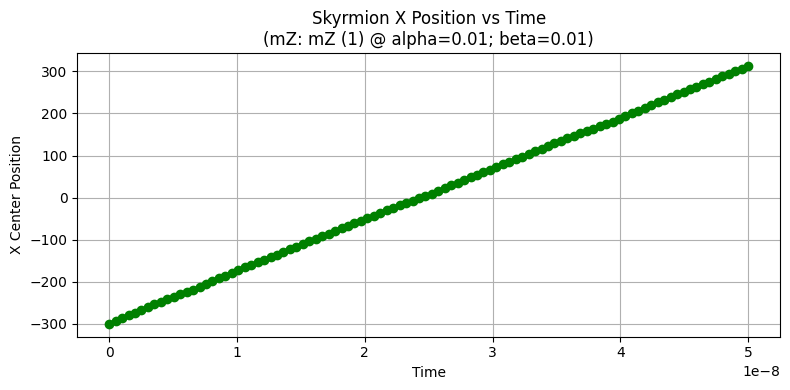

In [34]:

# ====== 选择 mZ 列 ======
mz_candidates = [col for col in df.columns if 'mZ' in col and '@' in col]
print("可选的 mZ 列：")
for i, col in enumerate(mz_candidates):
    print(f"[{i}] {col}")

mz_index = 9  # 修改这个 index 选择不同 mZ 列
mz_col = mz_candidates[mz_index]
print(f"\n使用的 mZ 列是: {mz_col}")

# ====== 初始化轨迹存储 ======
X_trajectory = {}
Y_trajectory = {}

# ====== 遍历所有时间帧计算中心位置 ======
for t, df_frame in df.groupby("t"):
    x_center, y_center, _ = find_skyrmion_center_by_clustering(
        df_frame,
        mz_col=mz_col,
        threshold=0.3,
        eps=8.0,
        min_samples=5
    )

    X_trajectory[t] = x_center
    Y_trajectory[t] = y_center

# ====== 准备数据用于绘图 ======
times = np.array(sorted(X_trajectory.keys()))
x_values = np.array([X_trajectory[t] for t in times])
y_values = np.array([Y_trajectory[t] for t in times])

# ====== 绘图：Y vs Time ======
plt.figure(figsize=(8, 4))
plt.plot(times, y_values, marker='o')
plt.xlabel("Time")
plt.ylabel("Y Center Position")
plt.title(f"Skyrmion Y Position vs Time\n(mZ: {mz_col})")
plt.grid(True)
plt.tight_layout()
plt.show()

# ====== 绘图：X vs Time ======
plt.figure(figsize=(8, 4))
plt.plot(times, x_values, marker='o', color='green')
plt.xlabel("Time")
plt.ylabel("X Center Position")
plt.title(f"Skyrmion X Position vs Time\n(mZ: {mz_col})")
plt.grid(True)
plt.tight_layout()
plt.show()

Preprocessing for single csv (fixed jX)

In [47]:
X = df["% X"]
Y = df["Y"]
t = df["t"]

results = []
for col in range(3, num_cols, 5):
   # print(f"Column {col}: {df.columns[col]}")
   mX = df.columns[col]
   mY = df.columns[col + 1]
   mZ = df.columns[col + 2]
   alpha = df.columns[col + 3]
   beta = df.columns[col + 4]

   alpha_value = (df[alpha].values[0])
   beta_value = (df[beta].values[0])

   # ====== 初始化轨迹存储 ======
   X_trajectory = {}
   Y_trajectory = {}

   # ====== 遍历所有时间帧计算中心位置 ======
   for t, df_frame in df.groupby("t"):
      x_center, y_center, _ = find_skyrmion_center_by_clustering(
         df_frame,
         mz_col=mZ,
         threshold=0.3,
         eps=8.0,
         min_samples=5
      )

      X_trajectory[t] = x_center
      Y_trajectory[t] = y_center

   # ====== 准备数据用于绘图 ======
   times = np.array(sorted(X_trajectory.keys()))
   x_values = np.array([X_trajectory[t] for t in times])
   y_values = np.array([Y_trajectory[t] for t in times])

   y_amp = np.max(y_values) - np.min(y_values)
   result = "success" if y_amp < 20 else "fail"

   results.append({
      "alpha": alpha_value,
      "beta": beta_value,
      "result": result
   })

print(results)
# 将结果转换为 DataFrame 并保存
results_df = pd.DataFrame(results)
output_csv_path = "../Data_Preprocessing/Preprocessed_Output/skyrmion_center_results.csv"
results_df.to_csv(output_csv_path, index=False)
print(f"Results saved to {output_csv_path}")

   
 
   


KeyboardInterrupt: 

In [43]:
print(df["t"].values[0])

0.0
